In [1]:
# Utilities
from pathlib import Path
import os
import subprocess as sp

# Data
import pandas as pd
import numpy as np

# Brain
import nibabel as nb
from nibabel.freesurfer.io import read_annot, read_label, read_morph_data
import cortex
import src.mesh_laplace_sulci

# Plotting
from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt


In [2]:



# project_dir = Path('/Users/benparker/Desktop/cnl/CNL_scalpel/results/')
# subjects_dir = Path('/Users/benparker/Desktop/cnl/subjects/')
# subjects_dir_str = '/Users/benparker/Desktop/cnl/subjects/'

# ## read_annot returns [0] labels at each vertex, -1 for no id [1]: ctab [2]: label names 
# annot_verts, annot_ctab, annot_names = read_annot(subjects_dir / '100307/label/rh.aparc.a2009s.annot')


# # import test subject to pycortex db
# cortex.freesurfer.import_subj('100307', freesurfer_subject_dir=subjects_dir_str, whitematter_surf='white')


def read_label(label_name):
    """
    Reads a freesurfer-style .label file (5 columns)
    
    Parameters
    ----------
    label_name: str 
    
    Returns 
    -------
    vertices: index of the vertex in the label np.array [n_vertices] 
    RAS_coords: columns are the X,Y,Z RAS coords associated with vertex number in the label, np.array [n_vertices, 3] 
    
    """
    
    # read label file, excluding first two lines of descriptor 
    df_label = pd.read_csv(label_name,skiprows=[0,1],header=None,names=['vertex','x_ras','y_ras','z_ras','stat'],delimiter='\s+')
    
    vertices = np.array(df_label.vertex) 
    RAS_coords = np.empty(shape = (vertices.shape[0], 3))
    RAS_coords[:,0] = df_label.x_ras
    RAS_coords[:,1] = df_label.y_ras
    RAS_coords[:,2] = df_label.z_ras
    
    return vertices, RAS_coords



In [3]:
## Load labels for boundary sulci


vertices, coords = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')


r_data = np.array([ras[0] for ras in coords])
a_data = np.array([ras[1] for ras in coords])
s_data = np.array([ras[2] for ras in coords])




In [9]:
def find_inferior_boundary(read_label, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along inferior boundary of given Freesurfer label.

    Bins all vertices along anterior axis, effecitvly getting every vertex in a coronal slice rounded to the decimal_size,
    and returns coordinates with the lowest Superior axis value in that column.

    INPUT:
    read_label = list [vertices, coordinates] : as outputed from read_label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin anterior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    inferior_boundary_vertex_num = np array; vertex number for each minimum Superior value along anterior axis
    inferior_boundary_coords = np array; RAS coordinates for each minimum Superior value along anterior axis


    Example:

    output_vertex_number, output_vertex_coords = find_inferior_boundary(read_label('home/subjects/100307/label/lh.MCGS.label'))


    """
  
    vertex_num = read_label[0]
    ras_coords = read_label[1]

    
    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])

    inferior_boundary_coords = []
    inferior_boundary_vertex_num = []
    rounded_anterior = np.round(a_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to inferior boundary
    for anterior in np.unique(rounded_anterior):
      # get all vertices with shared A coordinate
      column_idx = np.where(rounded_anterior == anterior)[0]
      # find minimum S coordinate from that column of points
      min_val = np.amin(s_data[column_idx])
      # be sure idx is drawn from original column idxes
      all_min_idx = np.where(s_data == min_val)[0]
      column_min_idx = np.intersect1d(all_min_idx, column_idx)
      # add inferior boundary and vertex to list

      inferior_boundary_coords.append(list(ras_coords[column_min_idx][0]))
      inferior_boundary_vertex_num.append(vertex_num[column_min_idx][0])
      

    mean_boundary_coord = np.mean([i[2] for i in inferior_boundary_coords])
    std_boundary_coord = np.std([i[2] for i in inferior_boundary_coords])
    
    # Keep coordinate if S coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      inferior_boundary_coords_outlier = []
      inferior_boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(inferior_boundary_coords):
          if coord_vert[2] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[2] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            inferior_boundary_coords_outlier.append(inferior_boundary_coords[i])
            inferior_boundary_vertex_num_outlier.append(inferior_boundary_vertex_num[i])
          else:
            pass
      return np.array(inferior_boundary_vertex_num_outlier), np.array(inferior_boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(inferior_boundary_vertex_num), np.array(inferior_boundary_coords)


vert_num, verts = find_inferior_boundary([vertices, coords], outlier_corrected=True, decimal_size=1)

r_data_min_inferior = np.array([ras[0] for ras in verts])
a_data_min_inferior = np.array([ras[1] for ras in verts])
s_data_min_inferior = np.array([ras[2] for ras in verts])



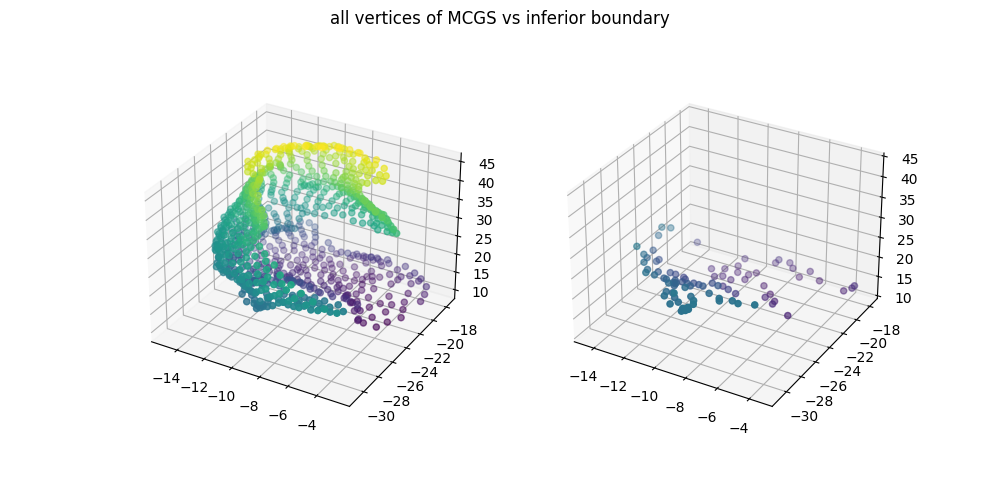

In [5]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax2.scatter3D(r_data_min, a_data_min, s_data_min, cmap='viridis', c=s_data_min, vmin=10, vmax=45)
ax2.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs inferior boundary')
plt.show();



In [10]:
def find_posterior_boundary(read_label, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along posterior boundary of given Freesurfer label.

    Bins all vertices along superior axis, effecitvly getting every vertex in a horizontal slice rounded to the decimal_size,
    and returns coordinates with the lowest superior axis value in that column.

    INPUT:
    read_label = list [vertices, coordinates] : as outputed from read_label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin superior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    posterior_boundary_vertex_num = np array; vertex number for each minimum Superior value along superior axis
    posterior_boundary_coords = np array; RAS coordinates for each minimum Superior value along superior axis


    Example:

    output_vertex_number, output_vertex_coords = find_posterior_boundary(read_label('home/subjects/100307/label/lh.MCGS.label'))


    """
  
    vertex_num = read_label[0]
    ras_coords = read_label[1]

    
    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])

    posterior_boundary_coords = []
    posterior_boundary_vertex_num = []
    rounded_superior = np.round(s_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to posterior boundary
    for superior in np.unique(rounded_superior):
      # get all vertices with shared A coordinate
      column_idx = np.where(rounded_superior == superior)[0]
      # find minimum S coordinate from that column of points
      min_val = np.amin(s_data[column_idx])
      # be sure idx is drawn from original column idxes
      all_min_idx = np.where(s_data == min_val)[0]
      column_min_idx = np.intersect1d(all_min_idx, column_idx)
      # add posterior boundary and vertex to list

      posterior_boundary_coords.append(list(ras_coords[column_min_idx][0]))
      posterior_boundary_vertex_num.append(vertex_num[column_min_idx][0])
      

    mean_boundary_coord = np.mean([i[1] for i in posterior_boundary_coords])
    std_boundary_coord = np.std([i[1] for i in posterior_boundary_coords])
    
    # Keep coordinate if S coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      posterior_boundary_coords_outlier = []
      posterior_boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(posterior_boundary_coords):
          if coord_vert[1] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[1] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            posterior_boundary_coords_outlier.append(posterior_boundary_coords[i])
            posterior_boundary_vertex_num_outlier.append(posterior_boundary_vertex_num[i])
          else:
            pass
      return np.array(posterior_boundary_vertex_num_outlier), np.array(posterior_boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(posterior_boundary_vertex_num), np.array(posterior_boundary_coords)



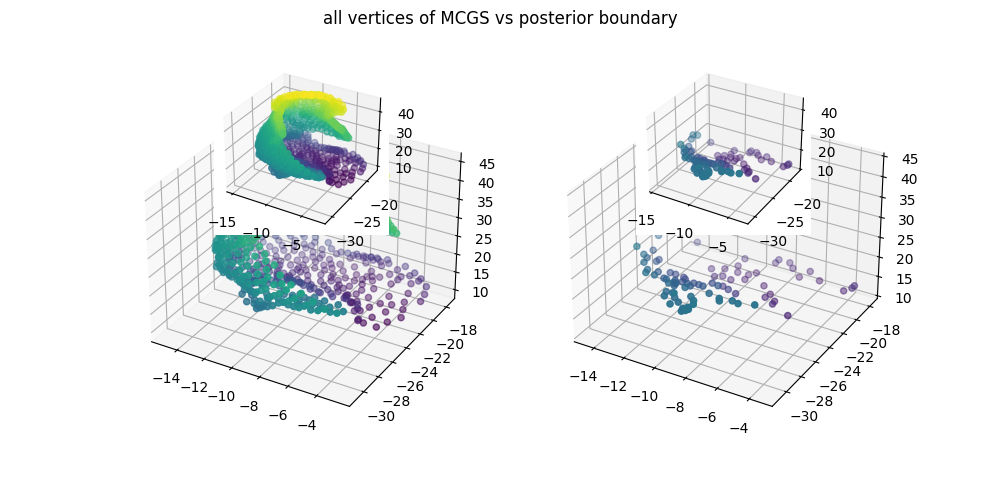

In [14]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax2.scatter3D(r_data_min_inferior, a_data_min_inferior, s_data_min_inferior, cmap='viridis', c=s_data_min_inferior, vmin=10, vmax=45)
ax2.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs inferior boundary')


vert_num_posterior, verts_posterior = find_posterior_boundary([vertices, coords], outlier_corrected=True, decimal_size=1)

r_data_min_posterior = np.array([ras[0] for ras in verts])
a_data_min_posterior = np.array([ras[1] for ras in verts])
s_data_min_posterior = np.array([ras[2] for ras in verts])

ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')
ax3.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax4.scatter3D(r_data_min_posterior, a_data_min_posterior, s_data_min_posterior, cmap='viridis', c=s_data_min_posterior, vmin=10, vmax=45)
ax4.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs posterior boundary')
plt.show();


In [189]:


## split FC map by boundary sulci

##### ID vertices within boundary by [0] from read annot